# Algortimos genéticos

Optimización de parámetros de Support Vector Machine con Kernel Gaussiano para una tarea de clasificación.

In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score as f1
from sklearn import cross_validation

from bitarray import bitarray
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
_fname = "/home/aecarrillor/ASAG/GoogleNews-vectors-negative300.bin"
w2vModel = Doc2Vec.load_word2vec_format(_fname, binary=True)

In [3]:
def w2vec_txts(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ])/
                       len([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel])) 
                       for StAns in txts])

def w2vec_txts_unorm(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ]))
                       for StAns in txts])

In [78]:
#Función Preprocesamiento
def xml_2_900_vec(path_prep_files):
#Parámetros
#path_prep_files = 'Training/' # 2-way scientist dataset (trainning)

    #Variables internas
    all_files =  glob.glob(path_prep_files+'*.xml')

    #Procesos

    ## crear array con id de pregunta, textos combinados y calificación.
    id_question=[]# Identificador de la pregunta (etiqueta de clase).
    calif=[]# Marca de criterio.
    quest=[]#Pregunta.
    ref_answer=[]#Respuesta de referencia.
    stud_answ=[]#Respuesta de estudiante.


    for doc in all_files:
        #print (doc)
        tree = ET.parse(doc)
        root = tree.getroot()
        question=root[0].text
        grade_st=[branch.attrib["accuracy"] for branch in root[2]]
        answers_st=[branch.text for branch in root[2]]
        answers_ref=[branch.text for branch in root[1]]# If there are more of 1 reference answer...
        for ith_ans,st_answ in enumerate(answers_st):
            quest.append(question)
            ref_answer.append(answers_ref[0])
            stud_answ.append(st_answ)
            id_question.append(root.attrib["id"])
            st_ans_calif=str(grade_st[ith_ans])
            calif.extend([1 if st_ans_calif=="correct" else 0])
            #print(id_question[ith_ans])

    ## Procesamiento Word2Vec
    w2v_questions=w2vec_txts(quest)
    w2v_RefAns=w2vec_txts(ref_answer)
    w2v_StudAns=w2vec_txts(stud_answ)

    Preg_RefAns_StAns=[]
    for i in xrange(len(w2v_questions)):
        vec_900=[]
        vec_900.extend(w2v_questions[i])
        vec_900.extend(w2v_RefAns[i])
        vec_900.extend(w2v_StudAns[i])
        Preg_RefAns_StAns.append(vec_900)

    return [Preg_RefAns_StAns,calif]

In [79]:
trainning=xml_2_900_vec('Training/')
X_train_w2v=trainning[0]
y_train_w2v=trainning[1]

In [80]:
unseen_ans=xml_2_900_vec('Test/test-unseen-answers/')
X_unseen_ans_w2v=trainning[0]
y_unseen_ans_w2v=trainning[1]

ZeroDivisionError: integer division or modulo by zero

In [81]:
unseen_doms=xml_2_900_vec('Test/test-unseen-domains/')
X_unseen_doms_w2v=trainning[0]
y_unseen_doms_w2v=trainning[1]

In [82]:
unseen_qstns=xml_2_900_vec('Test/test-unseen-questions/')
X_unseen_qstns_w2v=trainning[0]
y_unseen_qstns_w2v=trainning[1]

In [83]:
# Clasificador lineal optimizado con stochastic gradient descent.
svc = SGDClassifier(loss="hinge", penalty="l2", n_iter=1500)
svc.fit(X_train_w2v, y_train_w2v)

SGDClassifier(alpha=0.0001, class_weight=None, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=1500, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=False, verbose=0, warm_start=False)

In [84]:
yhat_a = svc.predict(X_unseen_ans_w2v)
f1_eval_w2v_a=f1(y_unseen_ans_w2v, yhat_a)
f1_eval_w2v_a

NameError: name 'X_unseen_ans_w2v' is not defined

In [ ]:
yhat = svc.predict(X_unseen_doms_w2v)
f1_eval_w2v=f1(y_unseen_doms_w2v, yhat)
f1_eval_w2v

In [ ]:
yhat_b = svc.predict(X_unseen_qstns_w2v)
f1_eval_w2v_b=f1(y_unseen_qstns_w2v, yhat_b)
f1_eval_w2v_b

In [ ]:
# Clasificador Kernel Gaussiano con parametros por defecto
svr = svm.SVC(kernel='rbf')
svr.fit(X_train_w2v, y_train_w2v)

y_est = svr.predict(X_unseen_doms_w2v)
f1_svr=f1(y_unseen_doms_w2v, y_est)
print ("Unseen Domains", f1_svr)

y_est_2 = svr.predict(X_unseen_qstns_w2v)
f1_svr_2=f1(y_unseen_qstns_w2v, y_est_2)
print ("Unseen Questions", f1_svr_2)

In [ ]:
# Clasificador Kernel Gaussiano - algoritmo evolutivo.
svr = svm.SVC(kernel='rbf', C=6.240234375, gamma=6.93359375)
svr.fit(X_train_w2v, y_train_w2v)

y_est = svr.predict(X_unseen_doms_w2v)
f1_svr=f1(y_unseen_doms_w2v, y_est)
print ("Unseen Domains", f1_svr)

y_est_2 = svr.predict(X_unseen_qstns_w2v)
f1_svr_2=f1(y_unseen_qstns_w2v, y_est_2)
print ("Unseen Questions", f1_svr_2)

# Funciones

In [86]:
def pop_indiv(bit_len=22):
    return ''.join([str(random.randint(0,1))for i in range(bit_len)])
    #return ''.join(['1' if bit==True else '0' for bit in bitarray(bit_len)])

def decode_indiv(indiv):
    half=len(indiv)/2
    c_param=    ((int(indiv[:half],2)+1)*20)/float(2**half)
    sigma_param=((int(indiv[half:],2)+1)*20)/float(2**half)
    return [c_param, sigma_param]

def svg_2(indiv):
    #decode_indiv(indiv)
    svr = svm.SVC(kernel='rbf', C=decode_indiv(indiv)[0], gamma=decode_indiv(indiv)[1])
    svr.fit(X_train_w2v, y_train_w2v)
    y_est = svr.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr


def pop_gener(pop_size, len_ind_bits=22):
    #Generador de poblaciones al azar
    return [pop_indiv(len_ind_bits) for i in xrange(pop_size)]#[bitarray(len_ind_bits) for indiv in xrange(N_pob)]

def fit_vector(population):
    svg_fit=[svg_2(ind) for ind in population]
    return svg_fit#prop_2

def selec_rulet(vec_fitness, n):
    # Devueleve una cantidad n de individuos a partir de la probabilidad proporcional a su fitness (mayor fitness, mayor probabilidad)
    elecs=[]
    probs=[float(p_i)/sum(vec_fitness) for p_i in vec_fitness]
    for i_num in xrange(n):
        r_num=random.random()
        cumsum=[sum(probs[:i+1]) for i in xrange(len(probs))]
        elec=None
        for i_sum in enumerate(cumsum):
            if r_num <= i_sum[1]:
                elec=i_sum[0]# devuleve el índice del seleccionado
                break
        elecs.append(elec)
    return elecs

def mutation(indiv, n_mutations=2):
    code=list(indiv)
    for i in xrange(n_mutations):
        loci=random.randint(0,len(indiv)-1)
        code[loci]=str(abs(int(code[loci])-1))
    return(''.join(code))

def fili(population,fits_popul,n_mutations=4):    
    ith_parents=selec_rulet(fits_popul, 2)
    parents=[population[ith] for ith in ith_parents]
    child_1=parents[0][:int(len(parents[0])*0.25)]+parents[1][int(len(parents[0])*0.25):int(len(parents[0])*0.5)]+parents[0][int(len(parents[0])*0.5):int(len(parents[0])*0.75)]+parents[1][int(len(parents[0])*0.75):]
    child_2=parents[1][:int(len(parents[0])*0.25)]+parents[0][int(len(parents[0])*0.25):int(len(parents[0])*0.5)]+parents[1][int(len(parents[0])*0.5):int(len(parents[0])*0.75)]+parents[0][int(len(parents[0])*0.75):]
    return ([mutation(child_1,n_mutations),mutation(child_2,n_mutations)])

def plot_experim(evolution):
    plt.figure(figsize=(15,8))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,3].astype(float))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,1].astype(float),"g")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,5].astype(float),"r--")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,6].astype(float),"k", alpha=0.4)
    plt.fill_between(xrange(len(evolution[:,3])),evolution[:,6].astype(float)+evolution[:,4].astype(float)*0.5,
                     evolution[:,6].astype(float)-evolution[:,4].astype(float)*0.5,alpha=.3, color="k")
    plt.show()

def experim(iteraciones=200, popul_size=100, bit_len=22, mutaciones=1, ref_rate=100):
    pars_1=pop_gener(popul_size, bit_len)
    evolution=[]
    fitness_population=fit_vector(pars_1)
    evolution=[[len(set(pars_1)),
                max(fitness_population),
                pars_1[fitness_population.index(max(fitness_population))],
                round(np.median(fitness_population),2),
                round(np.std(fitness_population),2),
                round(min(fitness_population),2),
                round(np.mean(fitness_population),2)
               ]]#propiedades de las poblaciones a lo largo de las generaciones

    for i in xrange(iteraciones):
        offsp=[]
        for i in range(popul_size/2):
            offsp.extend(fili(pars_1,fitness_population,mutaciones))
        inds_popul=len(set(offsp))
        fintess_offspring=fit_vector(offsp)
        best_fitness=max(fintess_offspring)
        best_indiv=offsp[fintess_offspring.index(max(fintess_offspring))]
        median_fit=round(np.median(fintess_offspring),2)
        desvest_fit=round(np.std(fintess_offspring),2)
        worst_fitness=round(min(fintess_offspring),2)
        avg_fit=round(np.mean(np.array(fintess_offspring).astype(float)),2)
        evolution.append([inds_popul,best_fitness,best_indiv,median_fit,desvest_fit,worst_fitness,avg_fit])
        # combinar  parents y offsp, y seleccionar.
        generations_AB=pars_1+offsp
        fitness_AB=fit_vector(generations_AB)
        # Selección Ranking
        ranking_df=pd.DataFrame({"indiv":generations_AB,"fit":fitness_AB}).sort_values(by="fit", ascending=False)
        next_gen=[str(bit_sec) for bit_sec in ranking_df["indiv"]]
        #Offspring elegidos
        pars_1=next_gen[:len(pars_1)]
        
        if math.modf(float(i)/ref_rate)[0]==0:
            plot_experim(evolution)
        
    evolution=np.array(evolution)
    evolution[:,3:]=evolution[:,3:].astype(float)
    return evolution

In [89]:
# #split data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v= train_test_split(trainning[0],trainning[1], test_size=0.25, random_state=42)

In [ ]:
corridas=1
iters=25
tama_pobl=10
mutacs=3
experimentos=[]
bst_fit_exps=[]
for i in xrange(corridas):
    corrida=experim(iteraciones=iters, popul_size=tama_pobl,mutaciones=mutacs)
    writer = csv.writer(open(''.join(["Results_SVG/corrida_",str(i),".csv"]), 'w'))
    for iterado in corrida:
        writer.writerow(iterado)
    bst_fit_exps.append(corrida[:,1])
    experimentos.append(corrida)
plt.plot(np.array(bst_fit_exps).T)

In [30]:
popul_size=50
population_1=[pop_indiv() for i in range(popul_size)]
svg_fit=[svg_2(ind) for ind in population_1]
decods=[decode_indiv(ind) for ind in population_1]

[[  1.015625     6.77734375   0.68722467]
 [  4.921875     2.90039062   0.72452069]
 [  3.29101562   5.703125     0.74569402]
 [ 14.84375     10.13671875   0.74104401]
 [  6.24023438   6.93359375   0.75379939]
 [  9.6875       5.12695312   0.74899598]
 [ 15.81054688   6.93359375   0.74395161]
 [ 17.33398438   9.52148438   0.73953013]
 [ 11.9140625    3.828125     0.75      ]
 [ 14.99023438  17.7734375    0.70011148]
 [  1.47460938   8.33007812   0.71931697]
 [  9.69726562   7.16796875   0.74823054]
 [ 10.18554688  16.73828125   0.71350165]
 [ 12.01171875   2.265625     0.72277228]
 [  4.16015625   7.58789062   0.74949084]
 [ 18.99414062   5.00976562   0.73673674]
 [  1.26953125  17.05078125   0.68571429]
 [  4.9609375    2.2265625    0.69772257]
 [  9.94140625  15.91796875   0.71381937]
 [  9.85351562   6.66015625   0.74672048]
 [ 13.76953125   8.671875     0.74036511]
 [ 17.734375    10.16601562   0.74104401]
 [ 19.39453125   4.54101562   0.73306773]
 [ 19.73632812  19.62890625   0.69

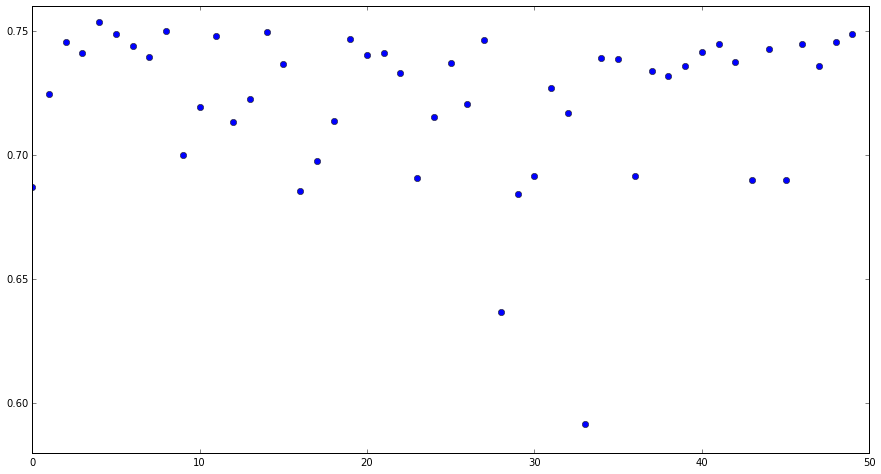

In [31]:
results=(np.array([population_1,np.array(decods)[:,0],np.array(decods)[:,1],svg_fit]).T)
results_float=(np.array([np.array(decods)[:,0],np.array(decods)[:,1],svg_fit]).T)
print(results_float)
plt.figure(figsize=(15,8))
plt.plot(svg_fit, "o")

In [32]:
# import csv
# #print ("decods",np.array(decods))
# writer = csv.writer(open("params_3.csv", 'w'))
# for i in range(len(svg_fit)):
#     #if counter[row[0]] >= 4:
#     writer.writerow(results[i])


(array([  1.,   0.,   1.,   0.,   0.,   3.,   7.,   6.,  10.,  22.]),
 array([ 0.59144893,  0.60768398,  0.62391902,  0.64015407,  0.65638912,
         0.67262416,  0.68885921,  0.70509425,  0.7213293 ,  0.73756435,
         0.75379939]),
 <a list of 10 Patch objects>)

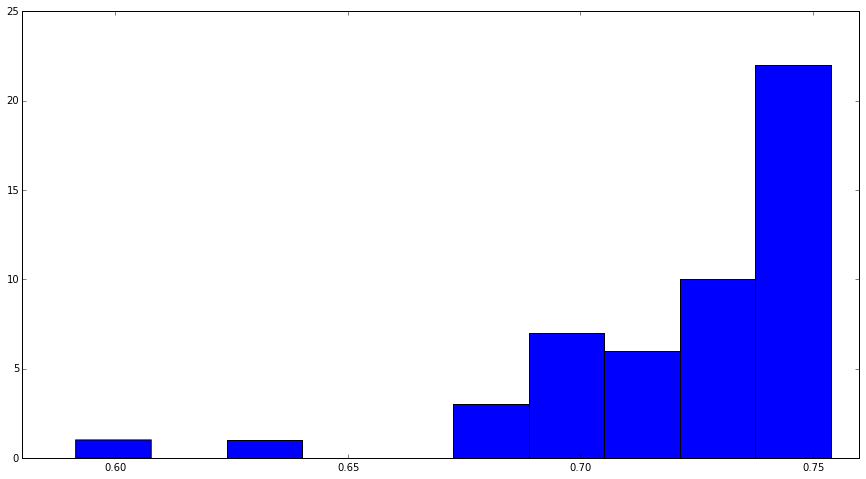

In [33]:
plt.figure(figsize=(15,8))
plt.hist(svg_fit)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

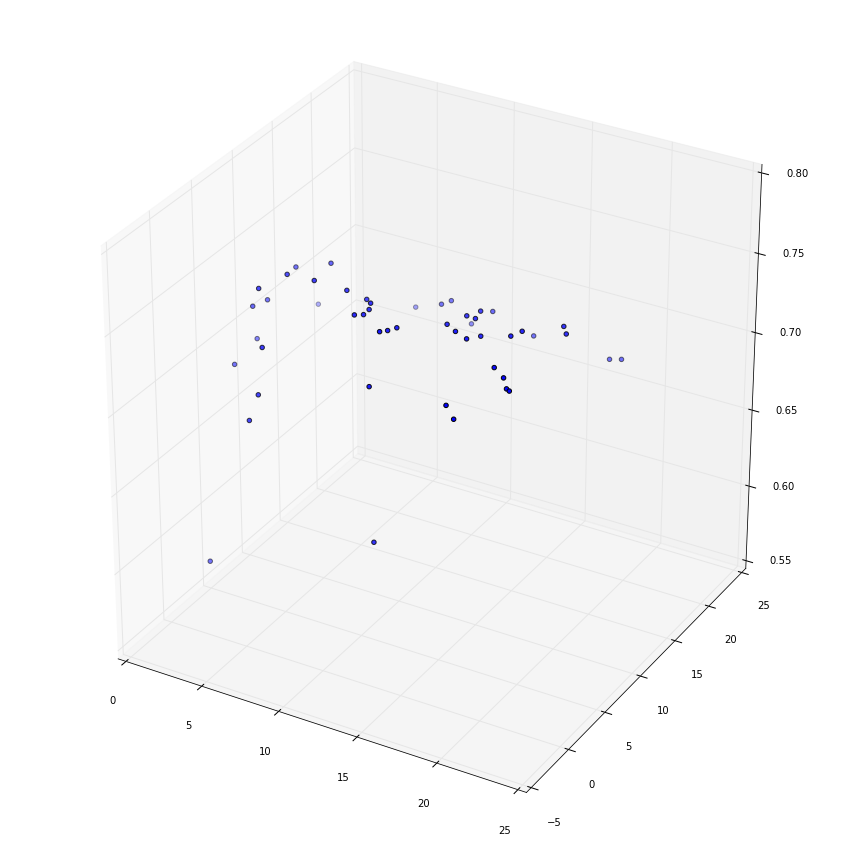

In [35]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(float(results[:,1]),float(results[:,2]),float(results[:,3]))
ax.scatter(np.array(decods)[:,0],np.array(decods)[:,1], svg_fit)
plt.show()


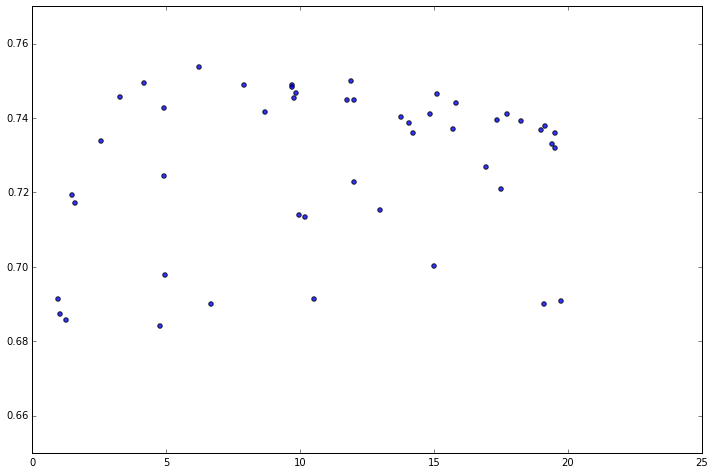

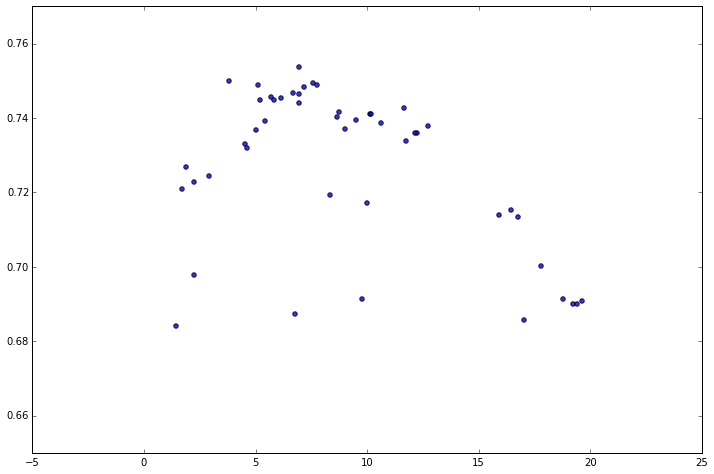

In [36]:
#C param
plt.figure(figsize=(12,8))
plt.scatter(np.array(decods)[:,0],svg_fit, alpha=0.8)
#plt.xlim([3,9])
plt.ylim([0.65, 0.77])
plt.show()

#Gamma
plt.figure(figsize=(12,8))
plt.scatter(np.array(decods)[:,1],svg_fit, alpha=0.8)
#plt.xlim([3, 9])
plt.ylim([0.65, 0.77])
plt.show()


# Test_Code


In [41]:
print (max(svg_fit))
print (svg_fit.index(max(svg_fit)))
bst=svg_fit.index(max(svg_fit))
print (decods[bst])
population_1[bst]

0.753799392097
4
[6.240234375, 6.93359375]


'0100111111001011000101'

In [23]:
results_best= [
    [0,6.8359375,4.66796875,0.75301205],
    [0,5.623413251903491,6.6899022280750415,0.74872838250254325],
    [0,5.81054688,6.00585938,0.75151515],
    ['0100111111001011000101',6.24023438,6.93359375,0.75379939]
    ]